In [1]:
# Montar o google drive no coolab}
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer

import warnings
from sklearn.exceptions import UndefinedMetricWarning
from tqdm import tqdm

## Importando dataframes

In [48]:
df_treino = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/gpt-3/1-10_relevancia/train_D_relevancia_1to10_all.pkl')
df_teste = pd.read_pickle('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/gpt-3/1-10_relevancia/teste_D_relevancia_1to10.pkl')

In [ ]:
df_treino.head()

,User_ID,Diagnosed_YN,Text,label
0,CD_9349,no,[Olha quem voltooouuuuu! Quero ser twittera no...,"[2, 1, 2, 6, 3, 3, 2, 1, 6, 2, 6, 3, 2, 2, 3, ..."
1,CD_9719,no,"[@ Meu amigo, tocaram ""Depois de Nós"", e eu na...","[2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, ..."
2,CD_9723,no,[@ Eu sei bem... Eu vou lah soh que nao vou po...,"[2, 2, 0, 0, 1, 2, 1, 0, 1, 3, 1, 2, 2, 1, 3, ..."
3,CD_9814,no,[Ganhar de 0 X 0 do São Paulo : Não tem dinhei...,"[2, 2, 2, 2, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, ..."
4,CD_10190,no,[Depois de um Domingo Difícil...pude perceber ...,"[2, 3, ...a recompensa natural pelo tempo gast..."


In [ ]:
df_teste.head()

,User_ID,Diagnosed_YN,Text,label
0,CD_187,no,[@ Na minha cabeça ela tá sujo smp Kkkkkkkkkkk...,"[2, 6, 2, 1, 1, 1, 0, 1, 2, 1, 3, 2, 1, 2, 2, ..."
1,CD_197,no,[e mais um ponto: a sarah foi transfobica vari...,"[2, 3, 2, 3, 0, 3, 2, 6, 2, 0, 2, 2, 1, 1, 2, ..."
2,CD_198,no,[lumena te odeio mas não vai dar vamo ter que ...,"[3, 2, 3, 3, 6, 0, 2, 3, 2, 2, 1, 2, 2, 2, 1, ..."
3,CD_260,no,"[@ só gente bonita torce pro gil, gosto mt , ...","[0, 1, 2, 2, 0, 2, 0, 2, 3, 3, 7, 1, 2, 2, 0, ..."
4,CD_280,no,[mds o sono que eu tenho não é desse mundo não...,"[3, 1, 2, 6, 0, 6, 1, 1, 0, 2, 2, 3, 2, 1, 2, ..."


In [4]:
print('treino:', df_treino.shape)
print('teste:', df_teste.shape)

treino: (10776, 4)
teste: (2696, 4)


## Tratamento

In [49]:
df_treino.reset_index(inplace=True)
df_teste.reset_index(inplace=True)

In [50]:
df_treino['Numeric_Diagnosed_YN'] = df_treino['Diagnosed_YN'].map({'no': 0, 'yes': 1})
df_teste['Numeric_Diagnosed_YN'] = df_teste['Diagnosed_YN'].map({'no': 0, 'yes': 1})

In [51]:
# Faço a contagem de posts
def contar_posts(texto):
    return len(texto)

# df_treino['Qt_Messages'] = df_treino['Text'].apply(contar_posts)
df_teste['Qt_Messages'] = df_teste['Text'].apply(contar_posts)

In [52]:
def min_timeline(lista):
    return lista[- menor_timeline:]

# menor_timeline = df_treino['Qt_Messages'].min()
# df_treino['label_min'] = df_treino['label'].apply(min_timeline)

menor_timeline = df_teste['Qt_Messages'].min()
df_teste['label_min'] = df_teste['label'].apply(min_timeline)

## Funções
Desenvolvimento de funções para cálculos

### Cálculo da métrica f1-*latency*

Para cálculo da métrica de interesse f1-*latency* são necessárias algumas etapas representadas pelas funções abaixo.

In [9]:
def value_p(k):
    """Get the penalty value for the F latency measure.

    Parameters
    ----------
    k : int
        Median number of posts from the positive users.

    Returns
    -------
    penalty : float
        Penalty to use.
    """
    return -(np.log(1 / 3) / (k - 1))


def f_penalty(k, _p):
    """Get the penalty of the current user delay.

    Parameters
    ----------
    k : int
        Current user delay.
    _p : float
        Penalty.

    Returns
    -------
    f_penalty : float
        Penalty latency.
    """
    return -1 + (2 / (1 + np.exp((-_p) * (k - 1))))


def speed(y_pred, y_true, d, p):
    """Get speed for every user correctly classified as positive."""
    penalty_list = [
        f_penalty(k=d[i], _p=p)
        for i in range(len(y_pred))
        if y_pred[i] == 1 and y_true[i] == 1
    ]

    if len(penalty_list) != 0:
        return 1 - np.median(penalty_list)
    else:
        return 0.0


def f_latency(labels, true_labels, delays, penalty):
    """F latency metric.

    Metric proposed by Sadeque and others in [1]_.

    Parameters
    ----------
    labels : list of int
        Predicted label for each user.
    true_labels : list of int
        True label for each user.
    delays : list of int
        Decision delay for each user.
    penalty : float
        Penalty. Defines how quickly the penalty should increase.

    Returns
    -------
    f_latency_metric : float
        F latency measure.

    References
    ----------
    .. [1] `Sadeque, F., Xu, D., & Bethard, S. (2018, February). Measuring the
        latency of depression detection in social media. In Proceedings of the
        Eleventh ACM International Conference on Web Search and Data Mining
        (pp. 495-503).`_
    """
    f1_score = metrics.f1_score(y_pred=labels, y_true=true_labels, average="binary")
    speed_value = speed(y_pred=labels, y_true=true_labels, d=delays, p=penalty)

    return f1_score * speed_value

### Remoção de valores
Função auxiliar para remoção de valores zero e um da lista de notas

In [135]:
def remove(lista, lista_valores):
    """
    Remove zeros de uma lista.

    Parâmetros:
    lista (list): A lista de entrada da qual os zeros serão removidos.

    Retorna:
    list: Uma nova lista sem os zeros.
    """
    return [item for item in lista if item not in lista_valores]

### Ponto de corte

In [140]:
def youden_index(df_treino, lista_janela, metrica, target='label', retirar_notas=[]):
  '''
  Função para identificar o melhor ponto de corte a partir da estatística de youden dada uma janela de mensagens
  '''
  # Suprimir o warning UndefinedMetricWarning
  warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

  df_paremeters = pd.DataFrame(columns=['window', 'threshold'])

  for janela in lista_janela:
    # Tratando os dados e calculando somas e médias janeladas
    coluna_numerica = []
    coluna_janela_metrica = []

    for row in df_treino[target]:
      lista_numerica = []
      for item in row:
        try:
          objeto = int(item)
          if objeto > 10:
            objeto = 10
        except:
          objeto = 0
        lista_numerica.append(objeto)
      coluna_numerica.append(lista_numerica)

      # Métrica móvel
      metrica_movel = []
      for i in range(len(lista_numerica) - janela + 1):
          janela_movel = lista_numerica[i:i + janela]
          janela_movel = remove(janela_movel, retirar_notas)

          if metrica == 'media':
            valor_metrica = sum(janela_movel) / janela
          elif metrica == 'mediana':
            valor_metrica = statistics.median(janela_movel)
          elif metrica == 'soma':
            valor_metrica = sum(janela_movel)
          metrica_movel.append(valor_metrica)
      coluna_janela_metrica.append(metrica_movel)

    # Inserindo as colunas criadas
    df_treino[f'{metrica}_movel_prediction'] = coluna_janela_metrica

    # Calculando a média das médias em cada linha
    if metrica == 'media':
      df_treino[f'{metrica}'] = df_treino[f'{metrica}_movel_prediction'].apply(np.mean)
    if metrica == 'mediana':
      df_treino[f'{metrica}'] = df_treino[f'{metrica}_movel_prediction'].apply(np.median)
    if metrica == 'soma':
      df_treino[f'{metrica}'] = df_treino[f'{metrica}_movel_prediction'].apply(np.sum)

    # Calculando a curva ROC
    fpr, tpr, thresholds = roc_curve(df_treino['Numeric_Diagnosed_YN'], df_treino[f'{metrica}'])
    # Calculando a estatística de Youden
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]

    # Append nas possibilidades de parâmetros
    dict_to_append ={'window': [janela], 'threshold': [optimal_threshold]}

    df_paremeters = pd.concat([df_paremeters, pd.DataFrame(dict_to_append)])
  return df_paremeters

### Treinando modelo
Realizando treino do modelo e obtendo as métricas de performance


In [155]:
def treino_modelo(df, janela, corte, metrica='media', target='label', retirar_notas=[]):
    """
    Treina o modelo com os pontos de corte e janela a partir de uma métrica escolhida

    Parâmetros:
    df: DataFrame de treinamento
    janela: quantidade de mensagens a serem consideradas na janela móvel
    corte: valor de threshold de corte
    métrica: métrica utilizada como critério (media, mediana ou soma)

    Retorna:
    df_metrics: DataFrame contendo as métricas de performance do treinamento
    """
    # Inicializando o dataframe de métricas
    df_metrics = pd.DataFrame(columns=['window', 'cut', 'f1_latency', 'pos_f1', 'neg_f1',
                                       'wheighted_avg_f1', 'macro_precision', 'macro_recall', 'macro_f1'])

    # Tratando os dados e calculando somas e médias janeladas
    coluna_numerica = []
    coluna_janela_metrica = []

    for row in df[target]:
        lista_numerica = []
        for item in row:
            try:
                objeto = int(item)
                if objeto > 10:
                    objeto = 10
            except:
                objeto = 0
            lista_numerica.append(objeto)
        coluna_numerica.append(lista_numerica)

        # Métrica móvel
        metrica_movel = []
        for i in range(len(lista_numerica) - janela + 1):
            janela_movel = lista_numerica[i:i + janela]
            janela_movel = remove(janela_movel, retirar_notas)

            if metrica == 'media':
              valor_metrica = sum(janela_movel) / janela
            elif metrica == 'mediana':
              valor_metrica = statistics.median(janela_movel)
            elif metrica == 'soma':
              valor_metrica = sum(janela_movel)
            metrica_movel.append(valor_metrica)
        coluna_janela_metrica.append(metrica_movel)

    # Inserindo as colunas criadas
    df['tl_prediction_numeric'] = coluna_numerica
    df[f'{metrica}_movel_prediction'] = coluna_janela_metrica

    # Obtendo a predição e calculando a quantidade de mensagens necessárias para isso
    coluna_msgs_lidas = []
    coluna_respostas = []
    for i in range(len(df)):
        resposta = 0
        lista_prov = []
        for j in df[f'{metrica}_movel_prediction'][i]:
            if j < corte:
                lista_prov.append(j)
            elif j >= corte:
                lista_prov.append(j)
                resposta = 1
                break

        n_msgs = len(lista_prov) + (janela-1)

        coluna_msgs_lidas.append(n_msgs)
        coluna_respostas.append(resposta)

    # Inserindo no dataframe
    df['predict_Diagnosed_YN'] = coluna_respostas
    df['qt_msgs_lidas'] = coluna_msgs_lidas

    # Calculando métricas de performance
    y_train = df['Numeric_Diagnosed_YN']
    y_pred = df['predict_Diagnosed_YN']

    report = classification_report(y_pred, y_train, output_dict=True)

    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']

    pos_f1 = report['1']['f1-score']
    neg_f1 = report['0']['f1-score']
    wheighted_avg_f1 = report['weighted avg']['f1-score']

    # Medida f1-latency
    f1_latency = f_latency(df['predict_Diagnosed_YN'], df['Numeric_Diagnosed_YN'], df['qt_msgs_lidas'], 0.0078)

    dict_to_append = {'window': janela, 'cut': corte, 'f1_latency': f1_latency, 'pos_f1': pos_f1, 'neg_f1': neg_f1,
                      'wheighted_avg_f1': wheighted_avg_f1, 'macro_precision': macro_precision, 'macro_recall': macro_recall, 'macro_f1': macro_f1}

    df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)

    return df_metrics, df

### Categorização das notas

In [129]:
def categoriza_notas(lista_notas):
  lista_categorizada = []
  for nota in lista_notas:
    try:
      int(nota)
      if int(nota) <= 2:
        lista_categorizada.append(0)
      elif int(nota) <= 5:
        lista_categorizada.append(1)
      else:
        lista_categorizada.append(2)
    except:
      lista_categorizada.append(100)

  return lista_categorizada

## Testes para obtenção da solução final

Nesta seção estão os testes de janela e corte para a solução

### EDA das notas

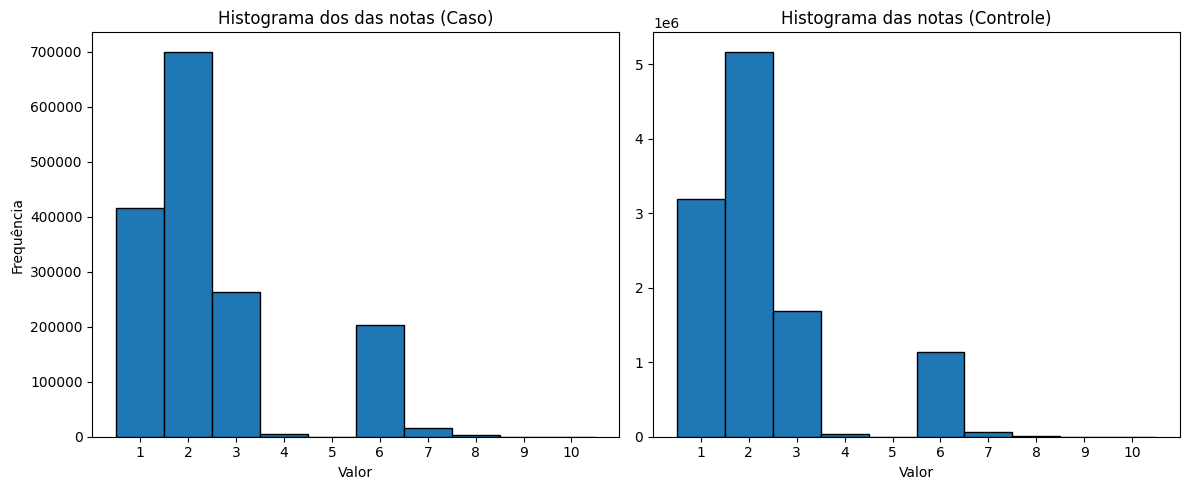

In [ ]:
# Filtrar o DataFrame em dois subconjuntos
df_case_1 = df_treino[df_treino['Numeric_Diagnosed_YN'] == 1]
df_case_0 = df_treino[df_treino['Numeric_Diagnosed_YN'] == 0]

# Flatten as colunas de listas para cada subconjunto
all_values_case_1 = [num for sublist in df_case_1['tl_prediction_numeric'] for num in sublist]
all_values_case_0 = [num for sublist in df_case_0['tl_prediction_numeric'] for num in sublist]

# Criar histogramas para cada subconjunto
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histograma para Numeric_Diagnosed_YN = 1
ax1.hist(all_values_case_1, bins=range(1, 12), edgecolor='black', align='left')
ax1.set_xlabel('Valor')
ax1.set_ylabel('Frequência')
ax1.set_title('Histograma dos das notas (Caso)')
ax1.set_xticks(range(1, 11))

# Histograma para Numeric_Diagnosed_YN = 2
ax2.hist(all_values_case_0, bins=range(1, 12), edgecolor='black', align='left')
ax2.set_xlabel('Valor')
ax2.set_title('Histograma das notas (Controle)')
ax2.set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

### Dataframe com amostra
Criando um dataframe de amostrar para realizar os testes

In [102]:
# Filtrando os dados
df_1 = df_treino[df_treino['Numeric_Diagnosed_YN'] == 1]
df_0 = df_treino[df_treino['Numeric_Diagnosed_YN'] == 0]

# Amostrando aleatoriamente
df_sample_1 = df_1.sample(n=100, random_state=42)
df_sample_0 = df_0.sample(n=700, random_state=42)

# Combinando as amostras
df_sample = pd.concat([df_sample_1, df_sample_0])

# Embaralhando as amostras para garantir que não haja ordenação
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

#### 0. Verificar se o resultado fica semelhante ao que temos hoje

In [41]:
df_metric_0 = treino_modelo(df_sample, 10, 2.155834, 'media', remove_zeros=False)
df_metric_0

<ipython-input-40-ea83e632317d>:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)


,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,10,2.155834,0.214146,0.226501,0.04742,0.222695,0.512143,0.563857,0.13696


#### 1. Usar a mediana

In [75]:
lista_janela = range(1, 10)
df_parameters = youden_index(df_sample, lista_janela, 'mediana', remove_zeros=False)
df_parameters

<ipython-input-73-8242f8b7a384>:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_paremeters = pd.concat([df_paremeters, pd.DataFrame(dict_to_append)])


,window,threshold
0,1,2.00
0,2,1.75
0,3,2.00
0,4,2.00
0,5,2.00
0,6,2.00
0,7,1.00
0,8,2.00
0,9,1.50


In [76]:
df_metric_1 = pd.DataFrame()
for index, row in df_parameters.iterrows():
   df_metric_1 = pd.concat([df_metric_1, treino_modelo(df_sample, row['window'], row['threshold'], 'mediana')])
df_metric_1

<ipython-input-74-d52ad02da3aa>:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-74-d52ad02da3aa>:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-74-d52ad02da3aa>:98: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,1,2.00,0.222222,0.222222,0.000000,0.222222,0.500000,0.062500,0.111111
0,2,1.75,0.220980,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208
0,3,2.00,0.220980,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208
0,4,2.00,0.220111,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208
0,5,2.00,0.219243,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208
0,6,2.00,0.218618,0.222965,0.008535,0.222161,0.502143,0.562735,0.115750
0,7,1.00,0.217023,0.222222,0.000000,0.222222,0.500000,0.062500,0.111111
0,8,2.00,0.217608,0.223714,0.016997,0.222163,0.504286,0.562972,0.120355
0,9,1.50,0.216736,0.223714,0.016997,0.222163,0.504286,0.562972,0.120355


In [77]:
df_metric_1.sort_values('f1_latency', ascending=False).head()

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,1,2.00,0.222222,0.222222,0.000000,0.222222,0.500000,0.062500,0.111111
0,2,1.75,0.220980,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208
0,3,2.00,0.220980,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208
0,4,2.00,0.220111,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208
0,5,2.00,0.219243,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208


#### 2. Retirar os Zeros

In [144]:
lista_janela = range(5, 15, 2)
df_parameters = youden_index(df_treino, lista_janela, 'media', retirar_notas=[0])

df_metric_2 = pd.DataFrame()
for index, row in df_parameters.iterrows():
   df_metric_2 = pd.concat([df_metric_2, treino_modelo(df_sample, row['window'], row['threshold'], 'media')])

<ipython-input-140-f7d93248115d>:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_paremeters = pd.concat([df_paremeters, pd.DataFrame(dict_to_append)])
<ipython-input-141-e08fd596286c>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-141-e08fd596286c>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no lon

In [145]:
df_metric_2

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,5,2.088298,0.219597,0.223964,0.019802,0.222178,0.505000,0.563052,0.121883
0,7,2.153357,0.217079,0.224972,0.030942,0.222304,0.507857,0.563371,0.127957
0,9,2.156176,0.216790,0.226501,0.047420,0.222695,0.512143,0.563857,0.136960
0,11,2.154545,0.211745,0.226757,0.050139,0.222783,0.512857,0.563939,0.138448
0,13,2.154590,0.211504,0.229358,0.076923,0.224023,0.520000,0.564767,0.153140


#### 3. Retirar valores Um

In [148]:
lista_janela = range(5, 15, 2)
df_parameters = youden_index(df_treino, lista_janela, 'media', retirar_notas=[1])

df_metric_3 = pd.DataFrame()
for index, row in df_parameters.iterrows():
   df_metric_3 = pd.concat([df_metric_3, treino_modelo(df_sample, row['window'], row['threshold'], 'media')])

<ipython-input-140-f7d93248115d>:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_paremeters = pd.concat([df_paremeters, pd.DataFrame(dict_to_append)])
<ipython-input-141-e08fd596286c>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-141-e08fd596286c>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no lon

In [147]:
df_metric_3

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,5,1.951479,0.220224,0.223714,0.016997,0.222163,0.504286,0.562972,0.120355
0,7,1.937112,0.218724,0.223964,0.019802,0.222178,0.505000,0.563052,0.121883
0,9,1.936782,0.218200,0.225225,0.033708,0.222352,0.508571,0.563452,0.129467
0,11,1.937799,0.215860,0.225989,0.041958,0.222538,0.510714,0.563694,0.133973
0,13,1.935132,0.214830,0.226757,0.050139,0.222783,0.512857,0.563939,0.138448


#### 4. Categorizar as notas

In [131]:
df_sample['nota_categorizada'] = df_sample['label'].apply(categoriza_notas)

lista_janela = range(3, 15)
df_parameters = youden_index(df_sample, lista_janela, 'media', target='nota_categorizada')

df_metric_4 = pd.DataFrame()
for index, row in df_parameters.iterrows():
   df_metric_4 = pd.concat([df_metric_4, treino_modelo(df_sample, row['window'], row['threshold'], 'media')])

<ipython-input-104-3495b88fc38f>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_paremeters = pd.concat([df_paremeters, pd.DataFrame(dict_to_append)])
<ipython-input-105-739c7e6195cc>:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-105-739c7e6195cc>:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no l

In [132]:
df_metric_4

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,3,0.299673,0.220489,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,4,0.299860,0.219622,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,5,0.300141,0.218756,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,6,0.300235,0.217889,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,7,0.300423,0.217023,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,8,0.300515,0.216157,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,9,0.300176,0.215291,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,10,0.300000,0.214425,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,11,0.299942,0.213560,0.222222,0.0,0.222222,0.5,0.0625,0.111111
0,12,0.299973,0.212695,0.222222,0.0,0.222222,0.5,0.0625,0.111111


#### 5. Ficar apenas com notas relevantes

In [225]:
lista_janela = range(5, 20, 2)
lista_corte = [1.5, 2, 2.5, 3]

df_metric_4 = pd.DataFrame()
for janela in lista_janela:
  for corte in lista_corte:
    df_temp, df = treino_modelo(df_sample, janela, corte, 'media', retirar_notas=[0, 1, 2])
    df_metric_4 = pd.concat([df_metric_4, df_temp])

<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, t

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,5,1.5,0.217762,0.225225,0.033708,0.222352,0.508571,0.563452,0.129467
0,5,2,0.211706,0.226244,0.044693,0.222613,0.511429,0.563776,0.135469
0,5,2.5,0.207953,0.232829,0.110661,0.226568,0.529286,0.565876,0.171745
0,5,3,0.207890,0.235294,0.133333,0.228922,0.535714,0.566667,0.184314
0,7,1.5,0.212502,0.225225,0.033708,0.222352,0.508571,0.563452,0.129467
0,7,2,0.210937,0.230681,0.090041,0.224879,0.523571,0.565189,0.160361
0,7,2.5,0.203914,0.236967,0.148148,0.230750,0.540000,0.567204,0.192557
0,7,3,0.186293,0.247788,0.264524,0.250068,0.566429,0.561737,0.256156
0,9,1.5,0.212510,0.228050,0.063624,0.223323,0.516429,0.564350,0.145837
0,9,2,0.207539,0.233372,0.115747,0.227050,0.530714,0.566050,0.174560


In [228]:
df_metric_4.sort_values('f1_latency', ascending=False)

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,5,1.5,0.217762,0.225225,0.033708,0.222352,0.508571,0.563452,0.129467
0,9,1.5,0.212510,0.228050,0.063624,0.223323,0.516429,0.564350,0.145837
0,7,1.5,0.212502,0.225225,0.033708,0.222352,0.508571,0.563452,0.129467
0,11,1.5,0.211830,0.230681,0.090041,0.224879,0.523571,0.565189,0.160361
0,5,2,0.211706,0.226244,0.044693,0.222613,0.511429,0.563776,0.135469
0,7,2,0.210937,0.230681,0.090041,0.224879,0.523571,0.565189,0.160361
0,13,1.5,0.208475,0.233918,0.120805,0.227556,0.532143,0.566225,0.177362
0,5,2.5,0.207953,0.232829,0.110661,0.226568,0.529286,0.565876,0.171745
0,5,3,0.207890,0.235294,0.133333,0.228922,0.535714,0.566667,0.184314
0,9,2,0.207539,0.233372,0.115747,0.227050,0.530714,0.566050,0.174560


In [222]:
# lista_janela = range(5, 29, 2)
# df_parameters = youden_index(df_treino, lista_janela, 'media', retirar_notas=[0, 1, 2])

# df_metric_4 = pd.DataFrame()
# for index, row in df_parameters.iterrows():
#    df_metric_4 = pd.concat([df_metric_4, treino_modelo(df_sample, row['window'], row['threshold'], 'media')])

In [152]:
df_metric_4

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,5,0.574924,0.218756,0.222222,0.000000,0.222222,0.500000,0.062500,0.111111
0,7,0.596134,0.217023,0.222222,0.000000,0.222222,0.500000,0.062500,0.111111
0,9,0.596591,0.215531,0.222469,0.002853,0.222195,0.500714,0.562578,0.112661
0,11,0.597350,0.213797,0.222469,0.002853,0.222195,0.500714,0.562578,0.112661
0,13,0.583865,0.212065,0.222469,0.002853,0.222195,0.500714,0.562578,0.112661
0,15,0.583114,0.210335,0.222469,0.002853,0.222195,0.500714,0.562578,0.112661
0,17,0.582801,0.208605,0.222469,0.002853,0.222195,0.500714,0.562578,0.112661
0,19,0.604096,0.206878,0.222469,0.002853,0.222195,0.500714,0.562578,0.112661
0,21,0.586504,0.205152,0.222469,0.002853,0.222195,0.500714,0.562578,0.112661
0,23,0.587219,0.203655,0.222717,0.005698,0.222175,0.501429,0.562657,0.114208


## Desenvolvimento da solução - sem modelo

In [229]:
# lista_janela = range(5, 15)
# df_parameters = youden_index(df_treino, lista_janela, 'media')
# df_parameters

In [160]:
# ## Média
# # Calculando a curva ROC
# fpr, tpr, thresholds = roc_curve(df_treino['Numeric_Diagnosed_YN'], df_treino['mean'])

# # Calculando a estatística de Youden
# youden_j = tpr - fpr
# optimal_idx = np.argmax(youden_j)
# optimal_threshold = thresholds[optimal_idx]

# print(f'O melhor ponto de corte é: {optimal_threshold}')
# auc = roc_auc_score(df_treino['Numeric_Diagnosed_YN'], df_treino['mean'])
# print(f'AUC: {auc}')

# plt.figure()
# plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(df_treino["Numeric_Diagnosed_YN"], df_treino["mean"]):.2f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal threshold = {optimal_threshold:.2f}')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) curve')
# plt.legend(loc='best')
# plt.show()

### Corpus de Treino

In [197]:
df_metrics=pd.DataFrame()
for index, row in df_parameters.iterrows():
  df_metrics_temp, df = treino_modelo(df_treino, row['window'], row['threshold'], 'media')
  df_metrics = pd.concat([df_metrics, df_metrics_temp])

<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, t

In [242]:
lista_janelas = range(5, 21, 5)
lista_cortes = [2, 2.5, 3]

df_metrics=pd.DataFrame()
for janela in lista_janelas:
  for corte in lista_cortes:
    df_metrics_temp, df = treino_modelo(df_treino, janela, corte, 'media', retirar_notas=[0, 1, 2])
    df_metrics = pd.concat([df_metrics, df_metrics_temp])

<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)
<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, t

In [243]:
df_metrics.sort_values('f1_latency', ascending=False)

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,5,2,0.212979,0.225731,0.043965,0.222104,0.510128,0.556654,0.134848
0,5,2.5,0.205521,0.229610,0.100191,0.223461,0.521211,0.551264,0.164900
0,5,3,0.203915,0.230796,0.114394,0.224434,0.524446,0.551746,0.172595
0,10,2,0.203135,0.232952,0.146638,0.226760,0.530385,0.549909,0.189795
0,15,2,0.192273,0.240361,0.260121,0.243091,0.549687,0.545636,0.250241
0,10,2.5,0.184402,0.245283,0.311446,0.256587,0.561141,0.547208,0.278365
0,20,2,0.172543,0.251742,0.413508,0.291568,0.574928,0.544160,0.332625
0,10,3,0.155706,0.257218,0.459849,0.314552,0.585322,0.545997,0.358534
0,15,2.5,0.143578,0.265106,0.525391,0.353655,0.598526,0.548009,0.395249
0,20,2.5,0.118067,0.281352,0.648940,0.453616,0.618464,0.552033,0.465146


In [234]:
df_metrics.sort_values('macro_f1', ascending=False).head(10)

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,19,2.5,0.119478,0.276103,0.618980,0.425364,0.612578,0.550091,0.447542
0,17,2.5,0.128491,0.271243,0.588398,0.399094,0.606480,0.548402,0.429820
0,18,2.5,0.129337,0.269006,0.579863,0.391808,0.603139,0.547203,0.424434
0,16,2.5,0.137980,0.265195,0.544894,0.365903,0.597996,0.546517,0.405045
0,15,2.5,0.143578,0.265106,0.525391,0.353655,0.598526,0.548009,0.395249
0,14,2.5,0.154388,0.259251,0.471701,0.321373,0.589034,0.547065,0.365476
0,13,2.5,0.167256,0.255025,0.423409,0.297527,0.581451,0.547211,0.339217
0,19,2,0.177913,0.249256,0.380831,0.278340,0.569891,0.544396,0.315044
0,11,2.5,0.175773,0.251277,0.376807,0.278454,0.574080,0.547766,0.314042
0,12,2.5,0.179504,0.250856,0.359442,0.272914,0.573232,0.549482,0.305149


In [183]:
df_metrics.sort_values('pos_f1', ascending=False).head()

,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2.155067,0.210089,0.226869,0.079097,0.221288,0.513946,0.541972,0.152983
0,13,2.154590,0.211333,0.226316,0.067335,0.221255,0.512249,0.543476,0.146826
0,11,2.154545,0.214527,0.225974,0.044983,0.222296,0.510765,0.559136,0.135479
0,9,2.156176,0.215616,0.225274,0.037457,0.222102,0.508803,0.557985,0.131366
0,7,2.153357,0.216913,0.224800,0.029055,0.222275,0.507371,0.563317,0.126927


In [ ]:
df_metrics.to_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/gpt-3/1-10_relevancia/metricas_treino_MinTL.csv', index=False)
# df_metrics = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/gpt-3/1-10_relevancia/metricas_treino_MinTL.csv')

Treinando melhor modelo

In [245]:
# janela = 15
# corte = 2.155067

janela = 15
corte = 2.5

In [246]:
df_metrics_temp, df_treino = treino_modelo(df_treino, janela, corte, 'media', retirar_notas=[0, 1, 2])

<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)


In [247]:
# MELHOR POR ENQUANTO
y_train_teste_1 = df_treino['Numeric_Diagnosed_YN']
y_pred_teste_1 = df_treino['predict_Diagnosed_YN']
print(classification_report(y_train_teste_1, y_pred_teste_1))

              precision    recall  f1-score   support

           0       0.94      0.36      0.53      9429
           1       0.16      0.83      0.27      1347

    accuracy                           0.42     10776
   macro avg       0.55      0.60      0.40     10776
weighted avg       0.84      0.42      0.49     10776




### Corpus de teste

#### Métricas de performance

In [248]:
janela = 15
corte = 2.5
df_metrics_teste, df_teste = treino_modelo(df_teste, janela, corte, target='label_min', retirar_notas=[0, 1, 2])
df_metrics_teste

<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)


,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2.5,0.236426,0.278455,0.838929,0.704424,0.595167,0.557069,0.558692


In [214]:
df_metrics_teste, df_teste = treino_modelo(df_teste, janela, corte, target='label_min', retirar_notas=[0, 1, 2])
df_metrics_teste

<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)


,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2,0.245863,0.268308,0.684364,0.485595,0.596651,0.542369,0.476336


In [195]:
df_metrics_teste, df_teste = treino_modelo(df_teste, janela, corte, target='label_min', retirar_notas=[0, 1, 2])
df_metrics_teste

<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)


,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2.155067,0.242071,0.272793,0.746687,0.561066,0.598347,0.545145,0.50974


In [172]:
df_metrics_teste, df_teste = treino_modelo(df_teste, janela, corte, target='label_min', retirar_notas=[])
df_metrics_teste

<ipython-input-155-56fc5cc7ab5a>:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_metrics = pd.concat([df_metrics, pd.DataFrame([dict_to_append])], ignore_index=True)


,window,cut,f1_latency,pos_f1,neg_f1,wheighted_avg_f1,macro_precision,macro_recall,macro_f1
0,15,2.155067,0.230635,0.243941,0.338087,0.26196,0.558499,0.541343,0.291014


In [249]:
# MELHOR POR ENQUANTO
y_train_teste_1 = df_teste['Numeric_Diagnosed_YN']
y_pred_teste_1 = df_teste['predict_Diagnosed_YN']
print(classification_report(y_train_teste_1, y_pred_teste_1))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      2359
           1       0.21      0.41      0.28       337

    accuracy                           0.74      2696
   macro avg       0.56      0.60      0.56      2696
weighted avg       0.82      0.74      0.77      2696



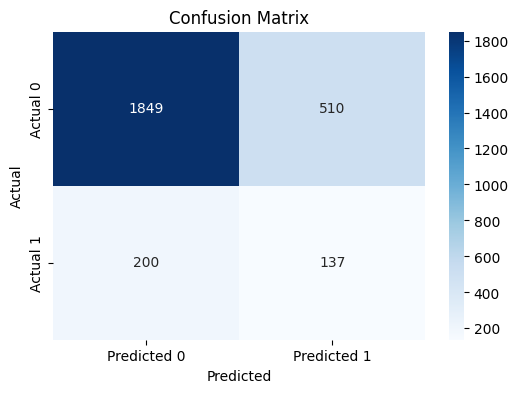

In [250]:
# Confusion matrix
cm = confusion_matrix(df_teste['Numeric_Diagnosed_YN'], df_teste['predict_Diagnosed_YN'])

# Exibindo a matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df_metrics_teste.to_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/gpt-3/1-10_relevancia/metricas_teste_MinTL.csv', index=False)
# df_metrics_teste = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/gpt-3/1-10_relevancia/metricas_teste_MinTL.csv')

df_teste.to_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/gpt-3/1-10_relevancia/prediction_GPTrelev_MinTL.csv', index=False)
# df_teste = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/gpt-3/1-10_relevancia/prediction_GPTrelev_MinTL.csv')

#### Tempo de antecipação
Neste seção vou calcular quanto tempo em média houve de antecipação do risco

In [251]:
df_teste_clean = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/gpt-3/1-10_relevancia/clean_test_corpus.csv')
df_teste_clean.head()

,User_ID,Diagnosed_YN,Text,List_Timeline,Week,CleanText
0,D_40,1,ESPALHEM ESSE TRABALHO INCRÍVEL$END_OF_POST$po...,"['09-Feb-2021 08:23', '09-Feb-2021 08:49', '09...","['06', '06', '06', '06', '06', '06', '06', '06...",esse trabalho incrvel$END_OF_POST$por deus eu ...
1,D_252,1,Nem eras$END_OF_POST$Mds eu tenho mais de 0 te...,"['20-Aug-2020 00:22', '20-Aug-2020 19:41', '20...","['33', '33', '33', '33', '33', '33', '33', '33...",eras$END_OF_POST$mds eu tenho mais de number t...
2,D_373,1,"oi! eu sou nova no edtwt, gostaria de encontra...","['08-Nov-2020 21:33', '08-Nov-2020 21:39', '08...","['45', '45', '45', '45', '45', '45', '45', '45...",eu sou nova no edtwt gostaria de encontrar mut...
3,D_99,1,Depois de 0 semana dormindo por volta das 20h ...,"['10-Jul-2020 21:52', '10-Jul-2020 22:02', '10...","['27', '27', '27', '27', '28', '28', '28', '28...",de number semana dormindo por volta das 20h e ...
4,D_1596,1,boa noite primeiramente$END_OF_POST$caramba co...,"['02-May-2018 22:37', '02-May-2018 22:39', '02...","['17', '17', '17', '17', '17', '17', '17', '17...",noite primeiramente$END_OF_POST$caramba como q...


In [ ]:
df_teste = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/depression/gpt-3/1-10_relevancia/prediction_GPTrelev_MinTL.csv')

In [252]:
df_teste_merged = pd.merge(df_teste, df_teste_clean[['User_ID', 'List_Timeline']], on='User_ID', how='left')

In [253]:
df_teste_merged['List_Timeline'] = df_teste_merged['List_Timeline'].apply(eval)

In [254]:
from datetime import datetime

# Função para converter a lista de datas em objetos datetime
def converter_datas(lista_datas_str):
    # Remover os colchetes e espaços em branco
    # lista_datas_str = lista_datas_str.strip('[]').replace("'", "").split(', ')
    # Converter cada data para datetime
    return [pd.to_datetime(data_str, format='%d-%b-%Y %H:%M') for data_str in lista_datas_str]


# Função para calcular a diferença em dias entre duas datas
def calcular_diferenca_dias(data1, data2):
    delta = data1 - data2
    return delta.days

# Aplicando a conversão de datas ao DataFrame
df_teste_merged['List_Timeline'] = df_teste_merged['List_Timeline'].apply(converter_datas)

# Aplicando a função ao DataFrame
df_teste_merged['ultima_data_tweet_lido'] = df_teste_merged.apply(lambda row: row['List_Timeline'][row['qt_msgs_lidas'] - 1], axis=1)
df_teste_merged['ultima_data_tweet_lista'] = df_teste_merged.apply(lambda row: row['List_Timeline'][-1], axis=1)
df_teste_merged['dias_antecipados'] = df_teste_merged.apply(lambda row: calcular_diferenca_dias(row['ultima_data_tweet_lista'], row['ultima_data_tweet_lido']), axis=1)

df_teste_merged.head()

,index,User_ID,Diagnosed_YN,Text,label,Numeric_Diagnosed_YN,Qt_Messages,label_min,tl_prediction_numeric,media_movel_prediction,predict_Diagnosed_YN,qt_msgs_lidas,List_Timeline,ultima_data_tweet_lido,ultima_data_tweet_lista,dias_antecipados
0,0,CD_187,no,[@ Na minha cabeça ela tá sujo smp Kkkkkkkkkkk...,"[2, 6, 2, 1, 1, 1, 0, 1, 2, 1, 3, 2, 1, 2, 2, ...",0,507,"[2, 0, 1, 2, 2, 1, 1, 2, 1, 6, 0, 0, 1, 0, 1, ...","[2, 0, 1, 2, 2, 1, 1, 2, 1, 6, 0, 0, 1, 0, 1, ...","[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, ...",0,83,"[2021-02-08 23:55:00, 2021-02-08 23:57:00, 202...",2021-02-16 07:34:00,2021-04-09 00:40:00,51
1,1,CD_197,no,[e mais um ponto: a sarah foi transfobica vari...,"[2, 3, 2, 3, 0, 3, 2, 6, 2, 0, 2, 2, 1, 1, 2, ...",0,507,"[3, 3, 6, 6, 6, 2, 6, 6, 3, 2, 3, 2, 2, 2, 0, ...","[3, 3, 6, 6, 6, 2, 6, 6, 3, 2, 3, 2, 2, 2, 0, ...","[2.8, 2.6, 2.4, 2.0, 2.0, 2.0, 2.0, 1.6, 1.2, ...",1,15,"[2021-03-12 15:07:00, 2021-03-12 15:20:00, 202...",2021-03-12 23:05:00,2021-04-09 17:21:00,27
2,2,CD_198,no,[lumena te odeio mas não vai dar vamo ter que ...,"[3, 2, 3, 3, 6, 0, 2, 3, 2, 2, 1, 2, 2, 2, 1, ...",0,507,"[1, 0, 2, 0, 3, 3, 1, 1, 1, 0, 3, 0, 6, 0, 3, ...","[1, 0, 2, 0, 3, 3, 1, 1, 1, 0, 3, 0, 6, 0, 3, ...","[1.2, 1.2, 1.2, 1.2, 1.2, 1.0, 0.8, 1.0, 1.2, ...",1,68,"[2021-02-28 23:51:00, 2021-03-01 00:06:00, 202...",2021-03-04 23:38:00,2021-04-09 16:00:00,35
3,3,CD_260,no,"[@ só gente bonita torce pro gil, gosto mt , ...","[0, 1, 2, 2, 0, 2, 0, 2, 3, 3, 7, 1, 2, 2, 0, ...",0,507,"[2, 0, 2, 2, 2, 2, 3, 0, 1, 2, 0, 3, 2, 6, 2, ...","[2, 0, 2, 2, 2, 2, 3, 0, 1, 2, 0, 3, 2, 6, 2, ...","[0.8, 1.2, 1.2, 1.4, 1.6, 1.8, 1.8, 1.6, 1.8, ...",1,27,"[2021-03-24 23:59:00, 2021-03-24 23:59:00, 202...",2021-03-26 13:06:00,2021-04-09 22:35:00,14
4,4,CD_280,no,[mds o sono que eu tenho não é desse mundo não...,"[3, 1, 2, 6, 0, 6, 1, 1, 0, 2, 2, 3, 2, 1, 2, ...",0,507,"[0, 2, 0, 0, 1, 0, 2, 3, 2, 1, 2, 1, 6, 0, 6, ...","[0, 2, 0, 0, 1, 0, 2, 3, 2, 1, 2, 1, 6, 0, 6, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.4, 1.4, 1.4, 1.2, ...",1,41,"[2021-03-10 20:28:00, 2021-03-10 22:06:00, 202...",2021-03-13 14:23:00,2021-04-09 16:54:00,27


In [255]:
dias_antecipacao_geral = df_teste_merged['dias_antecipados'].mean()
dias_antecipacao_pos = df_teste_merged[df_teste_merged['Numeric_Diagnosed_YN']==1]['dias_antecipados'].mean()
print(f'Média de dias de antecipação de risco geral: {dias_antecipacao_geral}')
print(f'Média de dias de antecipação de risco da classe positiva: {dias_antecipacao_pos}')

Média de dias de antecipação de risco geral: 525.8275222551929
Média de dias de antecipação de risco da classe positiva: 435.513353115727


In [ ]:
df_teste_merged.to_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/gpt-3/1-10_relevancia/prediction_GPTrelev_MinTL.csv', index=False)

#### Estatística descritiva das classificações de tweets

In [ ]:
df_teste = pd.read_csv('/content/drive/MyDrive/Mestrado/Dissertação/Experimentos/gpt-3/1-10_relevancia/prediction_GPTrelev_MinTL.csv')
df_teste.head()

,index,User_ID,Diagnosed_YN,Text,label,Numeric_Diagnosed_YN,Qt_Messages,label_min,tl_prediction_numeric,media_movel_prediction,soma_movel_prediction,predict_Diagnosed_YN,qt_msgs_lidas,List_Timeline,ultima_data_tweet_lido,ultima_data_tweet_lista,dias_antecipados
0,0,CD_187,no,['@ Na minha cabeça ela tá sujo smp Kkkkkkkkkk...,"['2', '6', '2', '1', '1', '1', '0', '1', '2', ...",0,507,"[2, 0, 1, 2, 2, 1, 1, 2, 1, 6, 0, 0, 1, 0, 1, ...","[2, 0, 1, 2, 2, 1, 1, 2, 1, 6, 0, 0, 1, 0, 1, ...","[0.0, 0.0, 1.8, 1.8, 2.0, 3.0, 2.6, 2.2, 2.2, ...","[0, 0, 9, 9, 10, 15, 13, 11, 11, 10, 9, 9, 3, ...",1,10,"[Timestamp('2021-02-08 23:55:00'), Timestamp('...",2021-02-09 23:10:00,2021-04-09 00:40:00,58
1,1,CD_197,no,['e mais um ponto: a sarah foi transfobica var...,"['2', '3', '2', '3', '0', '3', '2', '6', '2', ...",0,507,"[3, 3, 6, 6, 6, 2, 6, 6, 3, 2, 3, 2, 2, 2, 0, ...","[3, 3, 6, 6, 6, 2, 6, 6, 3, 2, 3, 2, 2, 2, 0, ...","[0.0, 0.0, 6.4, 7.0, 7.0, 6.2, 5.6, 4.8, 4.8, ...","[0, 0, 32, 35, 35, 31, 28, 24, 24, 20, 14, 12,...",1,7,"[Timestamp('2021-03-12 15:07:00'), Timestamp('...",2021-03-12 20:20:00,2021-04-09 17:21:00,27
2,2,CD_198,no,['lumena te odeio mas não vai dar vamo ter que...,"['3', '2', '3', '3', '6', '0', '2', '3', '2', ...",0,507,"[1, 0, 2, 0, 3, 3, 1, 1, 1, 0, 3, 0, 6, 0, 3, ...","[1, 0, 2, 0, 3, 3, 1, 1, 1, 0, 3, 0, 6, 0, 3, ...","[0.0, 0.0, 2.0, 2.0, 2.2, 1.8, 2.4, 1.8, 2.4, ...","[0, 0, 10, 10, 11, 9, 12, 9, 12, 11, 13, 13, 1...",1,9,"[Timestamp('2021-02-28 23:51:00'), Timestamp('...",2021-03-01 01:17:00,2021-04-09 16:00:00,39
3,3,CD_260,no,"['@ só gente bonita torce pro gil, gosto mt ',...","['0', '1', '2', '2', '0', '2', '0', '2', '3', ...",0,507,"[2, 0, 2, 2, 2, 2, 3, 0, 1, 2, 0, 3, 2, 6, 2, ...","[2, 0, 2, 2, 2, 2, 3, 0, 1, 2, 0, 3, 2, 6, 2, ...","[0.0, 0.0, 2.6, 2.2, 2.4, 2.4, 2.0, 2.2, 2.2, ...","[0, 0, 13, 11, 12, 12, 10, 11, 11, 14, 16, 21,...",1,7,"[Timestamp('2021-03-24 23:59:00'), Timestamp('...",2021-03-25 12:35:00,2021-04-09 22:35:00,15
4,4,CD_280,no,['mds o sono que eu tenho não é desse mundo nã...,"['3', '1', '2', '6', '0', '6', '1', '1', '0', ...",0,507,"[0, 2, 0, 0, 1, 0, 2, 3, 2, 1, 2, 1, 6, 0, 6, ...","[0, 2, 0, 0, 1, 0, 2, 3, 2, 1, 2, 1, 6, 0, 6, ...","[0.0, 0.0, 1.0, 1.6, 1.6, 1.8, 2.2, 2.2, 3.4, ...","[0, 0, 5, 8, 8, 9, 11, 11, 17, 15, 18, 16, 15,...",1,11,"[Timestamp('2021-03-10 20:28:00'), Timestamp('...",2021-03-11 20:49:00,2021-04-09 16:54:00,28


In [ ]:
import ast
from collections import Counter

# Tratando os dados de teste
# Transforma a coluna de string para lista
df_teste['label_min'] = df_teste['label_min'].apply(ast.literal_eval)

# Função para substituir valores não numéricos por 0
def limpar_lista(lista):
    nova_lista = []
    for item in lista:
        try:
            valor = int(item)
            if valor > 10:
              nova_lista.append(10)
            else:
              nova_lista.append(valor)
        except ValueError:
            nova_lista.append(0)  # Substitui por 0 se não for possível converter para inteiro
    return nova_lista

# Aplicar a função para limpar as listas na coluna 'label_min'
df_teste['label_min'] = df_teste['label_min'].apply(limpar_lista)

counter = Counter()
# Iterar sobre cada lista da coluna 'label_min' e atualizar o Counter com as contagens de cada valor
for lista in df_teste['label_min']:
    counter.update(lista)

In [ ]:
counter

Counter({2: 81378,
         0: 40561,
         1: 50928,
         6: 20442,
         3: 28413,
         7: 1292,
         4: 567,
         8: 182,
         10: 2,
         5: 3})

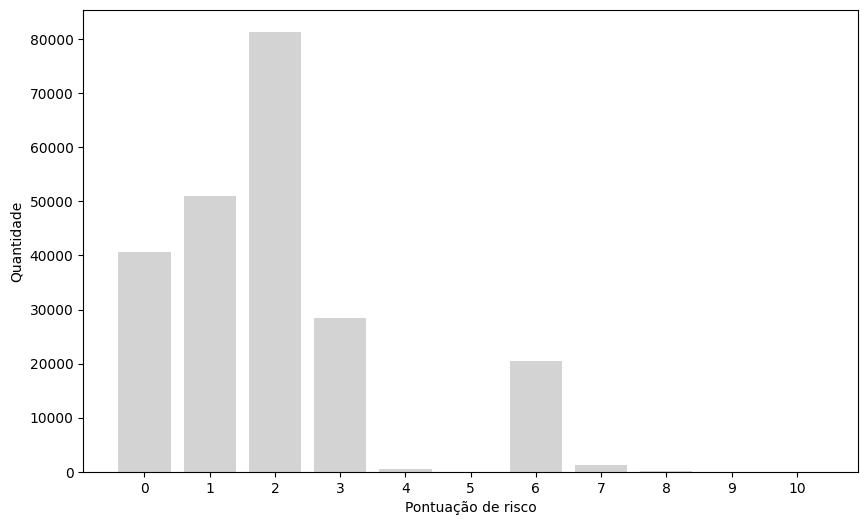

In [ ]:
# Converter o Counter para um DataFrame do pandas para facilitar a plotagem
histogram_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
histogram_df.columns = ['Número', 'Contagem']

# Ordenar os números
histogram_df = histogram_df.sort_values(by='Número')

# Plotar o histograma
plt.figure(figsize=(10, 6))
plt.bar(histogram_df['Número'], histogram_df['Contagem'], color='lightgrey')
plt.xlabel('Pontuação de risco')
plt.ylabel('Quantidade')
plt.xticks(range(11))
plt.show()

In [ ]:
histogram_df['percentual'] = (histogram_df['Contagem'] / histogram_df['Contagem'].sum()) * 100
histogram_df

,Número,Contagem,percentual
1,0,40561,18.126363
2,1,50928,22.759286
0,2,81378,36.367130
4,3,28413,12.697526
6,4,567,0.253387
9,5,3,0.001341
3,6,20442,9.135354
5,7,1292,0.577384
7,8,182,0.081334
8,10,2,0.000894
